In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import tqdm

%matplotlib inline

In [2]:
# If RAM is limited, set total_rows = 10000 or 100000; otherwise, set total_rows = None
total_rows = None
date = pd.read_csv('data/train_date.csv.zip', index_col=0, nrows=total_rows)

# Drop rows and columns if they are redundant
date.dropna(axis=0, how='all', inplace=True)
date.dropna(axis=1, how='all', inplace=True)

# Load labels
response = pd.read_csv('data/train_numeric.csv.zip', index_col=0, 
                       usecols=[0, 969], nrows=total_rows)

C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Restructure columns

Each column of date records a time stamp in the production line and tracks flows of parts. The columns follow a name convention of Line_Station_Feature.

The structure of production line, station, and feature is hierarchical, i.e., there is no feature belongs to two stations, and no station belongs to two lines. So we can restructure the columns.


In [3]:
# Extract station and feature names, and build a new pandas MultiIndex object
new_columns = pd.MultiIndex.from_tuples([tuple([int(a[1:]) 
                                          for a in x[3:].split('_')])
                                          for x in date.columns], 
                                          names=['station', 'feature'])
date.columns = new_columns

In [4]:
# Extract station names
stations = sorted([x for x in date.columns.levels[0]])

In [17]:
# Create station flow as strings
date_station = date.groupby(level=0, axis=1).sum().apply(
    lambda x: (x>0).astype(int).astype(str), raw=True).apply(
    lambda x: ''.join(x.values), axis=1)
date_station = pd.DataFrame(date_station).join(response)
date_station.columns = ['station_flow', 'Response']

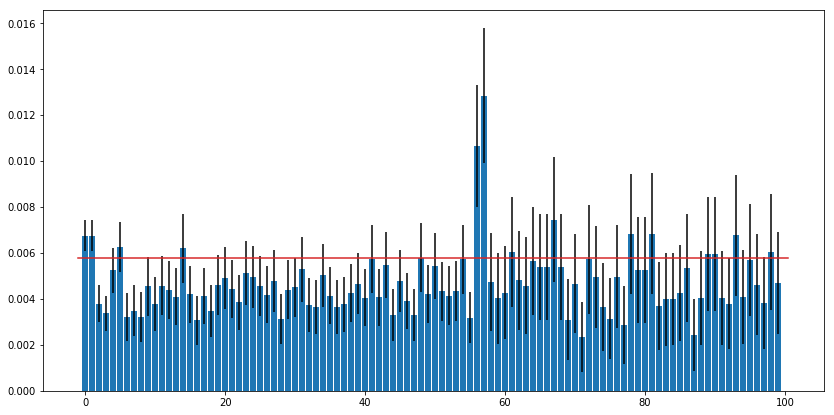

In [42]:
# Groupby station flows and visualize error rate
a = date_station.groupby('station_flow').Response.agg(['mean', 'sum', 'count'])
c = a.sort_values('count', ascending=False)
c['mean'] = c['mean']
c['confidence_interval'] = 1.96 * np.sqrt(c['mean'] * (1-c['mean']) / c['count'])
c['mean_low'] = c['mean'] - c['confidence_interval']
c['mean_high'] = c['mean'] + c['confidence_interval']

N = 100
plt.figure(figsize=(14, 7))
plt.bar(np.arange(N), c['mean'][:N], yerr=c['confidence_interval'][:N])
plt.plot([-1, N+0.5], [0.0058, 0.0058], color='tab:red', label='average error rate')